In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
# download train data from open datasets.
train_data=datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)
print(len(train_data))

# download test data from open datsets.
test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)
print(len(test_data))

# set the size of the training and evaluation sets
train_size = 50000
eval_size = 10000

# split the dataset into training and evaluation sets
train_data, eval_data = random_split(train_data, [train_size, eval_size])
print(len(train_data), len(eval_data))

60000
10000
50000 10000


In [ ]:
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [5]:
batch_size = 100

train_dl= DataLoader(train_data, batch_size = batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)
eval_dl = DataLoader(eval_data, batch_size=batch_size, shuffle=False)

In [6]:
device = 'cpu'
# 1 - 5 - 10 - 5 
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 28, 5)
        self.conv2 = nn.Conv2d(28, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, 128)  
        self.fc3 = nn.Linear(128, 10)
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu((self.conv3(x))))
        x = torch.flatten(x, 1)                 # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


In [21]:
def initial_check(model, test_dl):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    # testing loop
    with torch.no_grad():
        for data, labels in test_dl:
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = 100 * test_correct / test_total
    print(f"Validation Loss: {test_loss / len(test_dl)} Accuracy: {test_acc:.2f}%")

model = CNN()
initial_check(model, test_dl)

Validation Loss: 2.3047991609573364 Accuracy: 10.00%


In [18]:
def train_model(model, train_dl, test_dl, epochs, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, min_lr=0.000001) # use dynamic lr
    train_losses, test_losses = [], []              # to keep track of histoy of losses

    model.train()

    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss = 0.0
        current_lr = optimizer.param_groups[0]['lr']
        # training loop
        for inputs, outputs in train_dl:
            optimizer.zero_grad()
            inputs, outputs = inputs.to(device), outputs.to(device)
            pred = model(inputs)
            loss = criterion(pred, outputs)                                      # optimize
            loss.backward() 
            optimizer.step()
            train_loss += loss.item()
        
        print(f'At epoch {epoch} loss: {train_loss / len(train_dl)} with learning rate: {current_lr}')
        scheduler.step(train_loss)

        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0
        # testing loop
        with torch.no_grad():
            for data, labels in test_dl:
                data, labels = data.to(device), labels.to(device)

                outputs = model(data)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_acc = 100 * test_correct / test_total
        print(f"Validation Loss: {test_loss / len(test_dl)} Accuracy: {test_acc:.2f}%")

        test_losses.append(test_loss/len(test_dl))
        train_losses.append(train_loss/len(train_dl))
        
    print('Finished Training')

    return train_losses, test_losses

model = CNN()
# input size= 28x28
train_losses, test_losses = train_model(model, train_dl, test_dl, 20)

At epoch 0 loss: 0.6958079130649567 with learning rate: 0.001
Validation Loss: 0.4669290924072266 Accuracy: 82.53%
At epoch 1 loss: 0.38454418551921843 with learning rate: 0.001
Validation Loss: 0.3637856534123421 Accuracy: 86.90%
At epoch 2 loss: 0.3135516831576824 with learning rate: 0.001
Validation Loss: 0.3307983233034611 Accuracy: 87.61%
At epoch 3 loss: 0.2756026233434677 with learning rate: 0.001
Validation Loss: 0.32069759905338285 Accuracy: 88.68%
At epoch 4 loss: 0.25122273240983484 with learning rate: 0.001
Validation Loss: 0.2849931476265192 Accuracy: 89.98%
At epoch 5 loss: 0.23006474895775317 with learning rate: 0.001
Validation Loss: 0.2959082758426666 Accuracy: 89.45%
At epoch 6 loss: 0.21190067227184772 with learning rate: 0.001
Validation Loss: 0.27935025542974473 Accuracy: 90.37%
At epoch 7 loss: 0.19550036865472795 with learning rate: 0.001
Validation Loss: 0.29304766073822974 Accuracy: 89.91%
At epoch 8 loss: 0.18154868812114 with learning rate: 0.001
Validation L

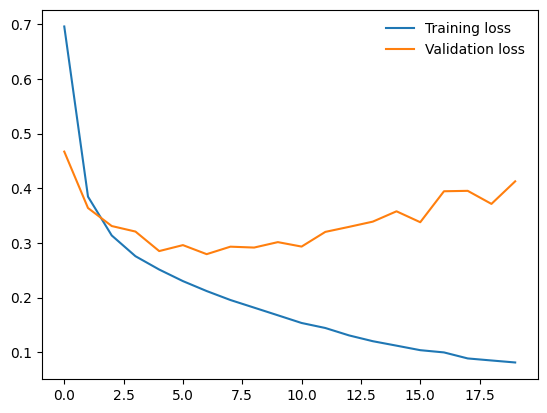

In [19]:
import matplotlib.pyplot as plt
# visualize training process
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)

In [9]:
file = 'cnn_model.pth'
torch.save(model.state_dict(), file)

In [20]:
def evaluate (eval_dl, model, criterion):
    model.eval()
    eval_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, outputs in eval_dl:
            inputs, outputs = inputs.to(device), outputs.to(device)
            pred = model(inputs)
            loss = criterion(pred, outputs)    

            eval_loss += loss.item()

            _, predicted = torch.max(pred, 1)               # get class with highest probability
            correct += (predicted == outputs).sum().item()  # count correctly predicted samples
            total += outputs.size(0)                        # keep track of total samples
        
        avg_loss = eval_loss / len(eval_dl)             # average loss over all batches
        accuracy = 100 * correct / total                # calculate accuracy as a percentage

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    
criterion = nn.CrossEntropyLoss()
evaluate(eval_dl, model, criterion)

Test Loss: 0.3751
Test Accuracy: 91.20%


In [16]:
from torch.autograd import Variable

def accuracy_per_class(test_dl, model):
    class_correct = [0. for _ in range(10)]
    total_correct = [0. for _ in range(10)]

    with torch.no_grad():
        for images, labels in test_dl:
            images, labels = images.to(device), labels.to(device)
            test = Variable(images)
            outputs = model(test)
            predicted = torch.max(outputs, 1)[1]
            correct = (predicted == labels).squeeze()
            
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                total_correct[label] += 1
            
    for i in range(10):
        print("Accuracy of {}: {:.2f}%".format(labels_map[i], class_correct[i] * 100 / total_correct[i]))

accuracy_per_class(test_dl, model)

Accuracy of T-shirt: 82.20%
Accuracy of Trouser: 95.40%
Accuracy of Pullover: 81.00%
Accuracy of Dress: 91.00%
Accuracy of Coat: 82.40%
Accuracy of Sandal: 95.70%
Accuracy of Shirt: 47.70%
Accuracy of Sneaker: 97.10%
Accuracy of Bag: 96.00%
Accuracy of Ankle Boot: 95.40%
